# UEFA Champions League 2019/2020 Round 16 Draw

As a football fan, every year, I follow with great attention where the best europeans teams meet, the Champions League. Around December, after the traditional group stages, comes the round 16 draw where only the two best teams of each group remain. The media begins to give different numbers for the probabilities of each match.

There are only three rules for the draw :
- a team that finished first will face one that was second
- two teams from the same country can not meet
- two teams from the same group can not meet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
nb_matchs = 8

In [2]:
# team (id, name, group_id, country_id)
teams_1 = [
    (0, "PSG", 0, 0),
    (1, "Bayern", 1, 2),
    (2, "Man City", 2, 3),
    (3, "Juve", 3, 4),
    (4, "Liverpool", 4, 3),
    (5, "Barcelona", 5, 1),
    (6, "Leipzig", 6, 2),
    (7, "Valence", 7, 1)
]

teams_2 = [
    (0, "Real Madrid", 0, 1),
    (1, "Tottenham", 1, 3),
    (2, "Atalanta", 2, 4),
    (3, "Atlético", 3, 1),
    (4, "Naples", 4, 4),
    (5, "Dortmund", 5, 2),
    (6, "Lyon", 6, 0),
    (7, "Chelsea", 7, 3) 
]

In [3]:
def get_group(team):
    return team[2]

def get_country(team):
    return team[3]

def is_eligible(team1, team2):
    return get_group(team1) != get_group(team2) and get_country(team1) != get_country(team2)

def get_possible_matchs(teams_1, teams_2):
    possible_matchs = []
    for team_1 in teams_1:
        matchs = []
        for team_2 in teams_2:
            if is_eligible(team_1, team_2):
                matchs.append(team_2[0])
        possible_matchs.append(matchs)    
    return possible_matchs

def explore_paths(possible_matchs):
    paths = [[]]
    all_draws = []
    
    while len(paths) > 0:
        path = paths.pop();
        if len(path) == nb_matchs:
            all_draws.append(path)
            continue
    
        matchs = [match for match in possible_matchs[len(path)] if match not in path]
        for match in matchs:
            new_path = path.copy()
            new_path.append(match)
            paths.append(new_path)
    return all_draws

A first approach already allows us to have an idea of the different possible matches with this set of rules.

In [4]:
possible_matchs = get_possible_matchs(teams_1, teams_2)
all_draws = explore_paths(possible_matchs)
print("Number of possible outcomes : %s" %(len(all_draws)))

Number of possible outcomes : 2002


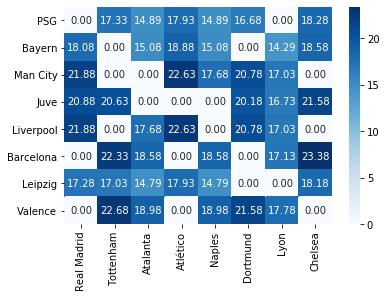

In [5]:
X_explore = np.zeros((nb_matchs, nb_matchs))
for draw in all_draws:
    for i in range(len(draw)): 
        X_explore[i, draw[i]] += 1
probabilities_explore = np.round(100 * (X_explore / X_explore.sum(axis=0)), 2)

dataframe_explore = pd.DataFrame(probabilities_explore)
dataframe_explore.index = [team_1[1] for team_1 in teams_1]
dataframe_explore.columns = [team_2[1] for team_2 in teams_2]
sns.heatmap(dataframe_explore, annot=True, fmt='.2f', cmap='Blues')

That's the method that some people also used

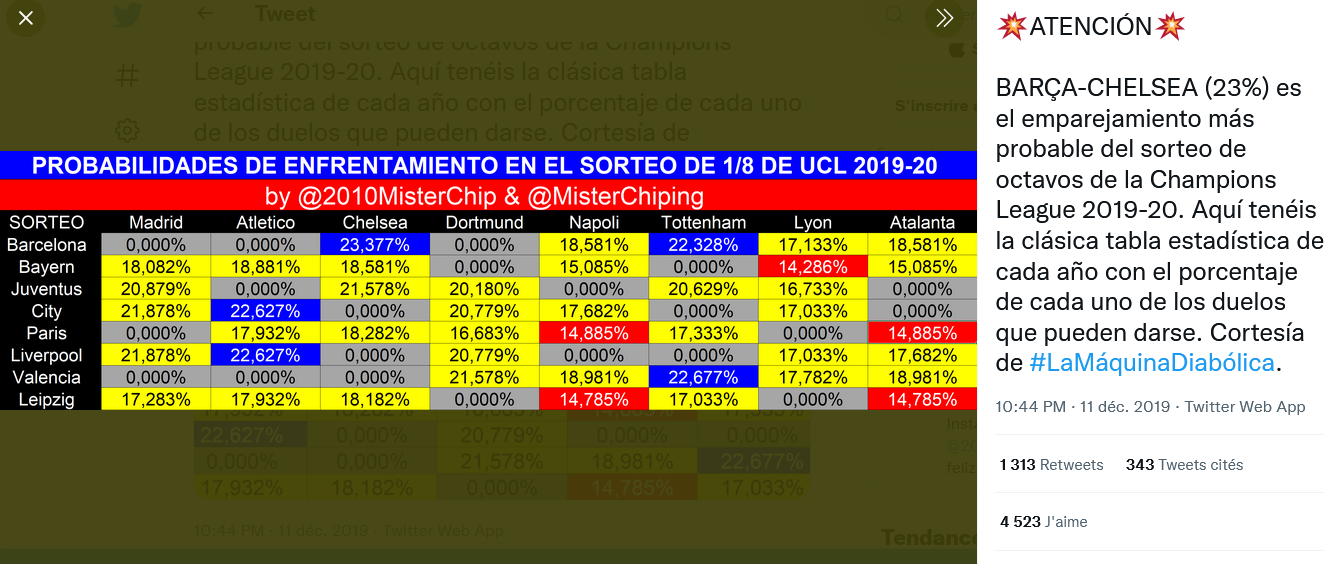

We will try to go one step further and simulate the draw in real conditions, it is important that at each step of the process, we can make a playable matching with the remaining teams.

In [6]:
def check_draw(draw, all_draws):
    for match in draw:
        all_draws = [path for path in all_draws if path[match[1]] == match[0]]
        if len(all_draws) == 0:
            return all_draws
    return all_draws

def convert_path(path):
    res = []
    for i,j in enumerate(path):
        res.append([i,j])
    return res

def remove_from_all_matchs(team_1, possible_matchs):
    for matchs in possible_matchs:
        if team_1 in matchs:
            matchs.remove(team_1)

def remove_possible_draws(match, draws):
    return [draw for draw in draws if match[0] == draw[match[1]]]

def convert_draws(paths):
    possible_matchs = []
    for i in range(nb_matchs):
        possible_matchs.append([])
    for path in paths:
        for i, match in enumerate(path):
            if match not in possible_matchs[i]:
                possible_matchs[i].append(match)
    return possible_matchs


def draw(teams_1, teams_2, all_draws):
    res = []
    possible_matchs = get_possible_matchs(teams_2, teams_1)
    teams_1_ids = [i for i in range(len(teams_1))]
    teams_2_ids = [i for i in range(len(teams_2))]
    
    while len(teams_2_ids) > 0:
        # we randomly choose a team that finished second
        team_2 = teams_2_ids[np.random.randint(0, len(teams_2_ids))]
        eligible_teams = possible_matchs[team_2]
        # we randomly choose a team that finished first and can face the selected team
        team_1 = eligible_teams[np.random.randint(0, len(eligible_teams))]
        res.append([team_1, team_2])
        # we check that the remaining teams can play together
        paths = check_draw(res, all_draws)
        
        if len(paths) == 1:
            return convert_path(paths[0])
        elif len(paths) > 0:
            teams_1_ids.remove(team_1)
            teams_2_ids.remove(team_2)
            # we refine the remaining paths possible
            possible_matchs = convert_draws(paths)
            all_draws = remove_possible_draws([team_1, team_2], all_draws)
        else:
            res.remove([team_1, team_2])
            possible_matchs[team_2].remove(team_1)
    return res

In [ ]:
N = 1000000
draws = []
for i in range(N):
    if i % 10000 == 0:
        print(i)
    draws.append(draw(teams_1, teams_2, all_draws))

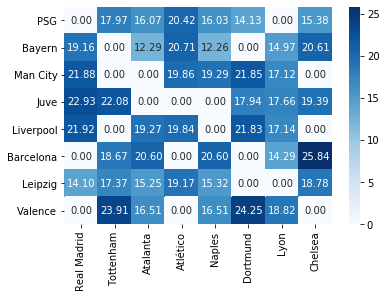

In [8]:
X = np.zeros((nb_matchs, nb_matchs))
for draw in draws:
    for match in draw:
        X[match[0], match[1]] += 1
probabilities = np.round(100 * (X / X.sum(axis=0)), 2)

dataframe = pd.DataFrame(probabilities)
dataframe.index = [team_1[1] for team_1 in teams_1]
dataframe.columns = [team_2[1] for team_2 in teams_2]
sns.heatmap(dataframe, annot=True, fmt='.2f', cmap='Blues')

With this approach, we reach a more precise result and every, we will be able to compute these probabilities.